In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import porespy as ps
import scipy as sp

import sys
sys.path.append("../src/")

import numpy as np
import pandas as pd

import torch

from torchvision.datasets import MNIST, KMNIST, CIFAR10, FashionMNIST
from torchvision.io import read_image

from torchvision.transforms.v2 import Compose
from torchvision.transforms.v2 import ToImage, Lambda, Resize, CenterCrop, Grayscale, ToDtype
from transforms import SoftThreshold, HardThreshold, Dilate

from sklearn.decomposition import PCA

import gudhi as gd
from tqdm import tqdm

import pickle

np.set_printoptions(precision=2, suppress=True, linewidth=120, edgeitems=45, threshold=100)
torch.set_printoptions(precision=2, sci_mode=False, linewidth=120, edgeitems=45, threshold=100)

[22:24:43] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=72516;file://C:\Users\ХХХ\AppData\Roaming\Python\Python310\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=889879;file://C:\Users\ХХХ\AppData\Roaming\Python\Python310\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
!pip install pypardiso
!pip install gudhi
!pip install --user porespy
!pip install matplotlib

  Using cached pypardiso-0.4.6-py3-none-any.whl.metadata (4.8 kB)
  Using cached mkl-2025.1.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached intel_openmp-2025.1.0-py2.py3-none-win_amd64.whl.metadata (1.3 kB)
  Using cached tbb-2022.1.0-py3-none-win_amd64.whl.metadata (1.1 kB)
  Using cached intel_cmplr_lib_ur-2025.1.0-py2.py3-none-win_amd64.whl.metadata (1.3 kB)
Using cached pypardiso-0.4.6-py3-none-any.whl (10 kB)
Using cached mkl-2025.1.0-py2.py3-none-win_amd64.whl (151.1 MB)
Using cached tbb-2022.1.0-py3-none-win_amd64.whl (299 kB)
Using cached intel_openmp-2025.1.0-py2.py3-none-win_amd64.whl (12.7 MB)
Using cached intel_cmplr_lib_ur-2025.1.0-py2.py3-none-win_amd64.whl (1.1 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Python310\\Library'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
def pht(image, pos=None, eps=None):
    
    if len(image.shape)!=3:
        raise ValueError("Image tensor dimensions should be (channel, width, height).")
    
    dim = 5 if pos is not None else 3
    dgm_pht = torch.zeros((0, dim))
    dgms = sublevel_persistence(image, eps=eps, pos=pos, sort="persistence")

    for i, dgm in enumerate(dgms):
        dgm_pht = torch.cat([dgm_pht, dgm])

    return dgm_pht

def sublevel_persistence(image, eps=None, pos=None, inf="max", sort="birth"):
    
    if len(image.shape)!=3:
        raise ValueError("Image tensor dimensions should be (channel, width, height).")
    
    diagrams = []
    persistence = lambda x: x[:,1] - x[:,0]
    
    # for each channel
    for k, channel in enumerate(image):
        diagram_channel_gudhi = gd.CubicalComplex(top_dimensional_cells=channel).persistence()
        
        # convert a diagram from GUDHI format to n x 3 ndarray
        diagram_channel = np.zeros((len(diagram_channel_gudhi), 3))
        for i, (dim, (birth, death)) in enumerate(diagram_channel_gudhi):
            diagram_channel[i] = (birth, death, dim)
    
        # work with infs
        if inf=="max":
            diagram_channel = np.nan_to_num(diagram_channel, posinf=torch.max(channel))
        elif inf=="remove":
            diagram_channel = diagram_channel[~np.isinf(diagram_channel).any(axis=1)]
        else:
            raise ValueError("Inf should be 'max' or 'remove'.")
            
        # remove points w/ persistence less \eps
        if eps is not None:
            diagram_channel = diagram_channel[persistence(diagram_channel) > eps]
            
        # add positional encoding
        if pos is not None:
            pos_elements = np.repeat(pos[k], len(diagram_channel))[..., np.newaxis]
            pos_idx = np.repeat(k, len(diagram_channel))[..., np.newaxis]
            diagram_channel = np.concatenate([diagram_channel, pos_elements, pos_idx], axis=1)
            
        # sort by dim, then birth or persistence
        if sort=="birth":
            sort_idx = np.lexsort([diagram_channel[:,0], diagram_channel[:,2]])
        elif sort=="persistence":
            sort_idx = np.lexsort([persistence(diagram_channel), diagram_channel[:,2]])
        else:
            raise ValueError("Sort should be 'birth' or 'persistence'.")
        diagram_channel = diagram_channel[sort_idx]
            
        diagrams.append(torch.tensor(diagram_channel))
        
    return diagrams

In [4]:
from typing import Any, Dict
from torchvision.transforms.v2 import Transform
from scipy.ndimage import rotate

def direction_filter(img, alpha, agg="mult"):
    if len(img.shape)==3:
        width, height = img.shape[1], img.shape[2]
    elif len(img.shape)==2:
        width, height = img.shape[0], img.shape[1]
    else:
        raise ValueError()
        
    if width==28:
        img_out = np.zeros((40, 40))
        img_out[6:34, 6:34] = img
        filter_hor = np.repeat(np.linspace(1, 0, 40), 40).reshape(40, 40).T
        filter_dir = (rotate(filter_hor, alpha, reshape=False))[6:34,:][:,6:34]
    elif width==32:
        img_out = np.zeros((46, 46))
        img_out[7:39, 7:39] = img
        filter_hor = np.repeat(np.linspace(1, 0, 46), 46).reshape(46, 46).T
        filter_dir = (rotate(filter_hor, alpha, reshape=False))[7:39,:][:,7:39]
    elif width==64:
        img_out = np.zeros((92, 92))
        img_out[14:78, 14:78] = img
        filter_hor = np.repeat(np.linspace(1, 0, 92), 92).reshape(92, 92).T
        filter_dir = (rotate(filter_hor, alpha, reshape=False))[14:78,:][:,14:78]
    else:
        raise ValueError("Only sizes of 28x28, 32x32, and 64x64 pixels are supported.")
        
    if agg=="mult":
        g = np.multiply
    elif agg=="add":
        g = np.add
    elif agg=="min":
        g = np.minimum
    elif agg=="max":
        g = np.maximum
    else:
        raise ValueError("Aggregation function is either 'mult', 'min' or 'max'.")
    
    return torch.Tensor(g(filter_dir, img))

class Direction(Transform):
    """Transform an image with the direction transform."""
    def __init__(self, alphas, agg="mult"):
        super().__init__()
        self.agg = agg
        self.alphas = alphas
        self.weight = alphas

    def transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        output = torch.zeros(len(self.alphas), inpt.shape[-2], inpt.shape[-1])
        for i, alpha in enumerate(self.alphas):
            output[i] = direction_filter(inpt, alpha, self.agg)
        return output

In [5]:
def imshow3d(img, ax):

    w, h = img.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    x, y = grid_x.ravel(), grid_y.ravel()

    width = depth = 1
    top = img.T.flatten()
    bottom = np.zeros_like(top)

    cmap = cm.get_cmap('bwr')
    rgba = [cmap(p) for p in top]
    
    ax.view_init(elev=60, azim=30, roll=0)
    ax.bar3d(x, y, bottom, width, depth, top, color=rgba, shade=True)

### MNIST

In [6]:
mnist_train = MNIST(root="../data/_tmp/", train=True, download=True)
mnist_test = MNIST(root="../data/_tmp/", train=False, download=True)

X_mnist_train, y_mnist_train = mnist_train.data, mnist_train.targets
X_mnist_test, y_mnist_test = mnist_test.data, mnist_test.targets

In [7]:
X_mnist_train.shape, X_mnist_test.shape, y_mnist_train.shape, y_mnist_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [8]:
transform_mnist = Compose([
    Lambda(lambda x: x / 255),
    ToDtype(torch.float32),
])

In [9]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

img = transform_mnist(X_mnist_train[1])
img_filtered = f(img)
img_filtered.shape

torch.Size([16, 28, 28])

In [27]:
sp = sublevel_persistence(X_mnist_train[1].unsqueeze(0))[0]

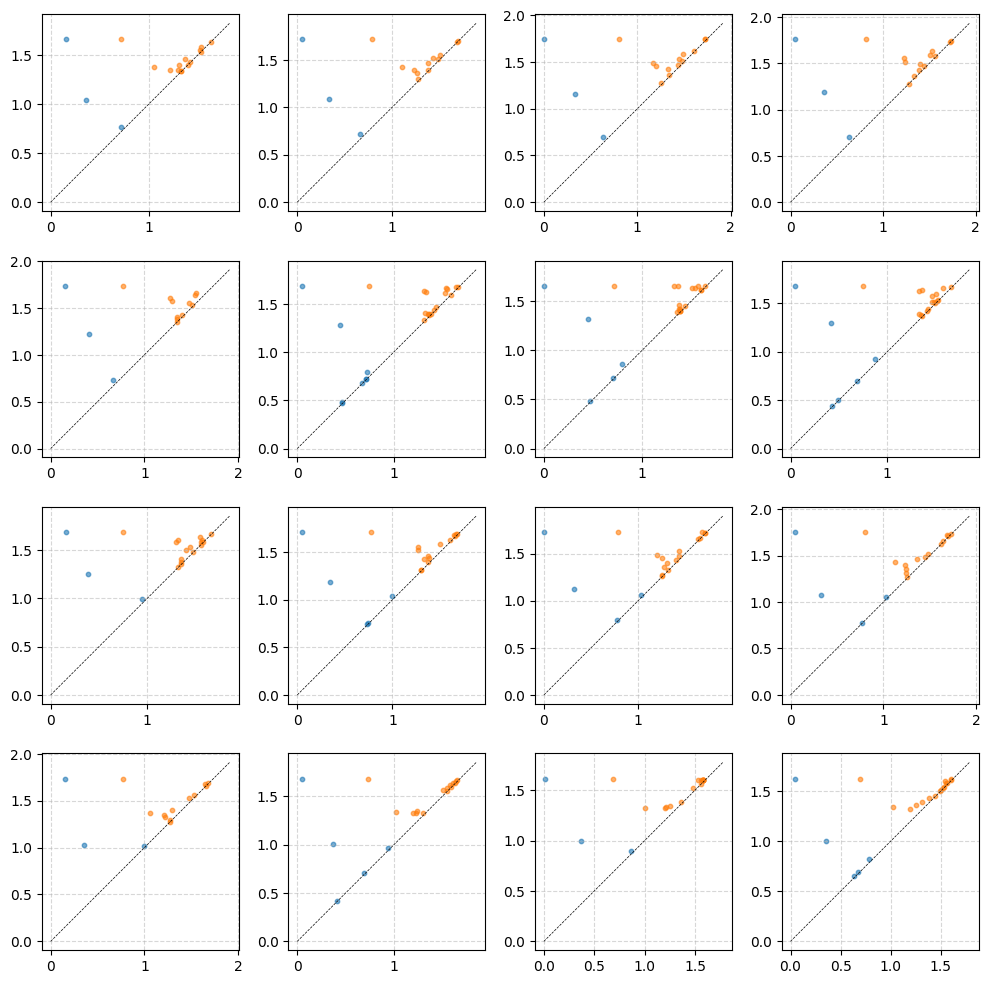

In [42]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()  # Преобразуем в 1D массив для удобства

for idx, ax in enumerate(axes):
    sp = sublevel_persistence(img_filtered[idx].unsqueeze(0))[0]
    birth = sp[:, 0]
    death = sp[:, 1]
    dim = sp[:, 2].int()

    for d in torch.unique(dim):
        mask = (dim == d)
        ax.scatter(birth[mask], death[mask], label=f'Dim {d.item()}', alpha=0.6, s=10)
    
    max_val = max(birth.max(), death.max()) + 0.1 * max(birth.max(), death.max())
    ax.plot([0, max_val], [0, max_val], 'k--', linewidth=0.5)
    
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.5)
    # ax.axis('off')
    # ax.set_xticks([])
    # ax.set_yticks([])

plt.tight_layout()
plt.show()

(-0.5, 27.5, 27.5, -0.5)

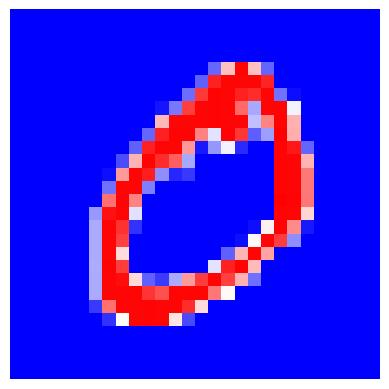

In [ ]:
plt.imshow(X_mnist_train[1], cmap='bwr')
plt.axis("off")

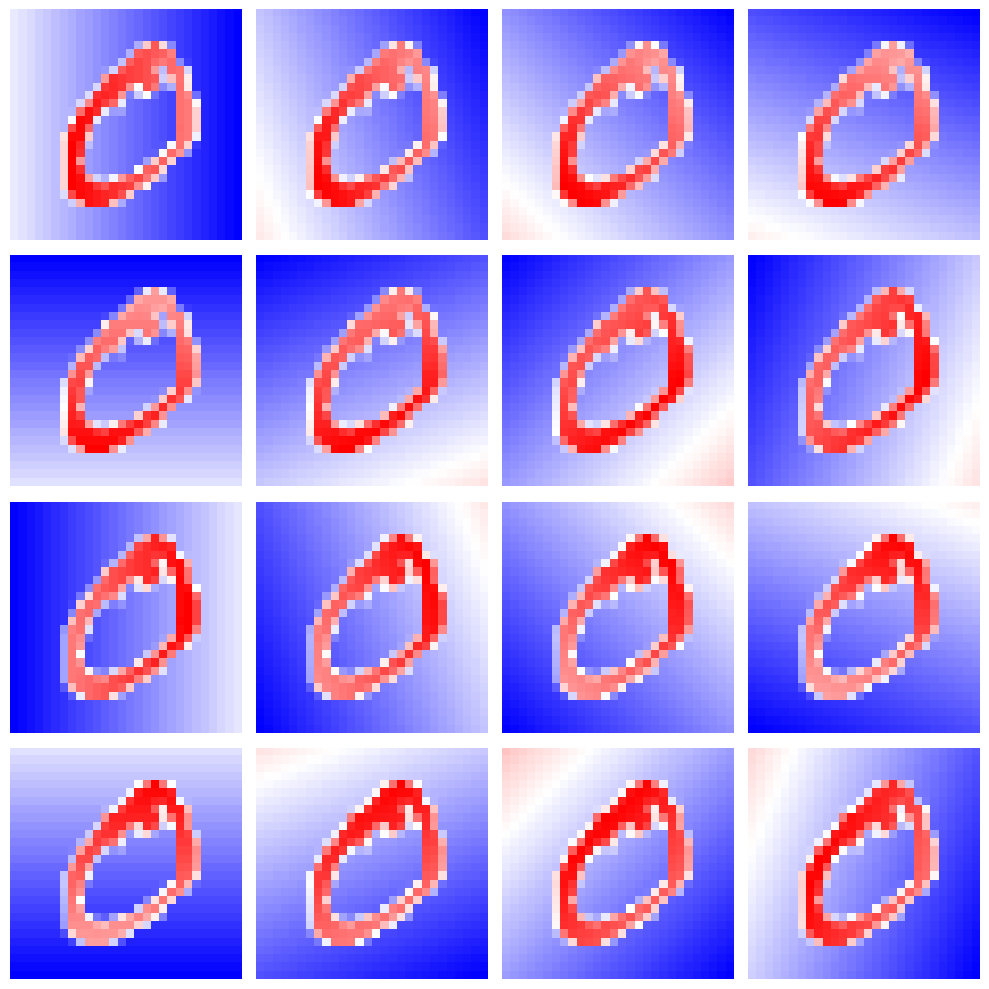

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Создаем сетку 4x4
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()  # Преобразуем в 1D массив для удобства

for idx, ax in enumerate(axes):
    ax.imshow(img_filtered[idx], cmap='bwr')
    ax.axis('off')  # Убираем оси

plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

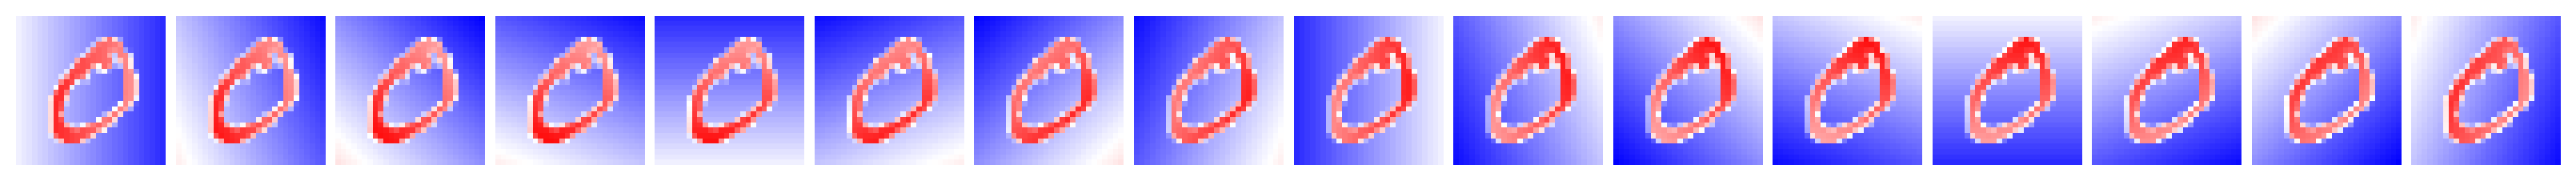

In [16]:
fig, ax = plt.subplots(ncols=len(img_filtered), figsize=(16, 1), dpi=200)
for i in range(len(img_filtered)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[i], vmin=0, vmax=1.8, cmap="bwr")
plt.tight_layout(pad=0.25)
plt.show()

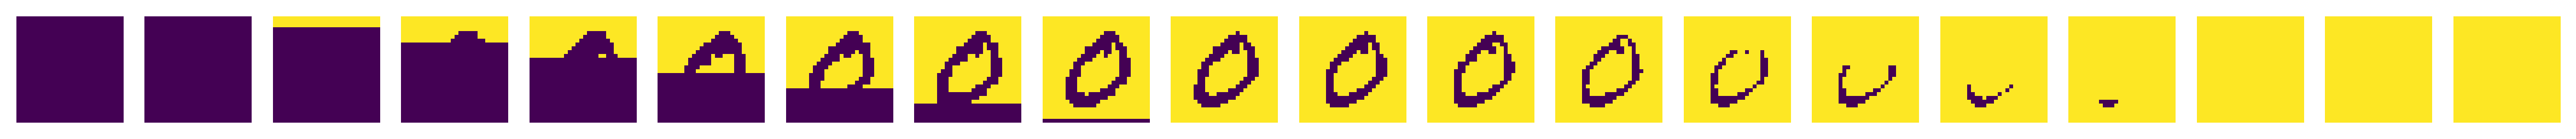

In [205]:
fig, ax = plt.subplots(ncols=20, figsize=(20, 1), dpi=300)
for i, t in enumerate(np.linspace(0, 2, 20)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[4] <= t, vmin=0, vmax=1)
plt.show()

/var/folders/29/7zhc2w2n7jn0l4p1tyzskm3w0000gn/T/ipykernel_25486/2076207902.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bwr')


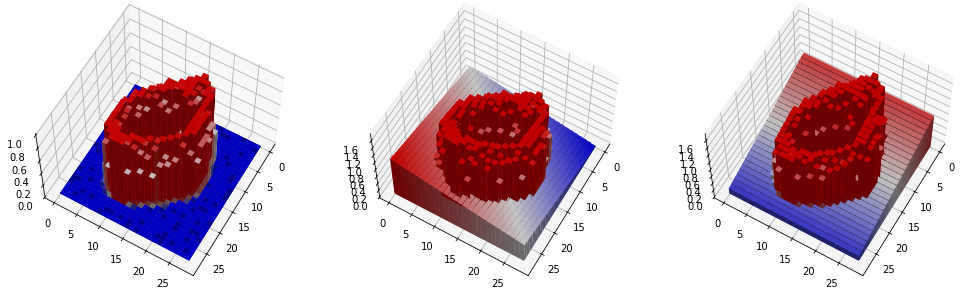

In [206]:
fig, ax = plt.subplots(ncols=3, subplot_kw=dict(projection="3d"), figsize=(17,5))
imshow3d(img, ax[0])
imshow3d(img_filtered[2], ax[1])
imshow3d(img_filtered[12], ax[2])
plt.show()

### Persistence

#### Sublevel

In [329]:
X_mnist_train_ = transform_mnist(X_mnist_train)
D_mnist_train_id = []

for i, img in enumerate(tqdm(X_mnist_train_)):
    dgm = sublevel_persistence(img.unsqueeze(0))[0]
    D_mnist_train_id.append(dgm)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:48<00:00, 1243.69it/s]


In [341]:
shapes_train_id = np.array([len(dgm) for dgm in D_mnist_train_id])
shapes_train_id.min(), shapes_train_id.mean(), shapes_train_id.max()

(1, 10.6641, 77)

In [353]:
D_mnist_train_id_pt = np.ones([len(D_mnist_train_id), shapes_train_id.max(), 3]) * np.nan

for i, dgm in enumerate(D_mnist_train_id):
    dgm_len = len(dgm)
    D_mnist_train_id_pt[i,:dgm_len] = dgm
    
D_mnist_train_id_pt = torch.tensor(D_mnist_train_id_pt)

In [357]:
mask_idx = torch.isnan(D_mnist_train_id_pt[:,:,0])
mask_idx.shape

torch.Size([60000, 77])

In [348]:
torch.tensor(D_mnist_train_id_pt)

tensor([[[0.00, 1.00, 0.00],
         [0.00, 1.00, 1.00],
         [0.67, 0.99, 1.00],
         [0.75, 0.99, 1.00],
         [0.88, 0.99, 1.00],
         [0.95, 0.99, 1.00],
         [0.99, 0.99, 1.00],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan

In [330]:
X_mnist_test_ = transform_mnist(X_mnist_test)
D_mnist_test_id = []

for i, img in enumerate(tqdm(X_mnist_test_)):
    dgm = sublevel_persistence(img.unsqueeze(0))[0]
    D_mnist_test_id.append(dgm)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1156.73it/s]


In [335]:
shapes_test_id = np.array([len(dgm) for dgm in D_mnist_test_id])
shapes_test_id.min(), shapes_test_id.mean(), shapes_test_id.max()

(1, 10.2343, 73)

In [359]:
D_mnist_test_id_pt = np.ones([len(D_mnist_test_id), shapes_test_id.max(), 3]) * np.nan

for i, dgm in enumerate(D_mnist_test_id):
    dgm_len = len(dgm)
    D_mnist_test_id_pt[i,:dgm_len] = dgm
    
D_mnist_test_id_pt = torch.tensor(D_mnist_test_id_pt)

In [338]:
np.unique(shapes_test_id, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 45, 47, 50, 51, 52, 55, 58, 63, 72, 73]),
 array([  1, 678, 731, 679, 678, 620, 597, 583, 566, 583, 590, 525, 471, 407, 388, 312, 275, 236, 202, 156, 158, 127,
         92,  91,  49,  56,  41,  17,  21,  11,  13,   7,   5,   2,   5,   4,   4,   2,   1,   2,   2,   1,   1,   1,
          2,   1,   2,   1,   1,   1,   1]))

In [340]:
pickle.dump(D_mnist_train_id, open("../data/MNIST_D_train_id.pkl", "wb"))
pickle.dump(D_mnist_test_id, open("../data/MNIST_D_test_id.pkl", "wb"))

In [358]:
torch.save(D_mnist_train_id_pt, "../data/MNIST_D_train_id.pt")

In [360]:
np.save("../data/MNIST_D_train_id.npy", D_mnist_train_id_pt)
np.save("../data/MNIST_D_test_id.npy", D_mnist_test_id_pt)

#### Directional

In [ ]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

X_mnist_train_ = transform_mnist(X_mnist_train)
D_mnist_train_dir = []

for i, img in enumerate(tqdm(X_mnist_train_)):
    dgm_pht = pht(f(img), pos=alphas)
    D_mnist_train_dir.append(dgm_pht)

pickle.dump(D_mnist_train_dir, open("../data/MNIST_D_train_dir.pkl", "wb"))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [14:07<00:00, 70.84it/s]


In [385]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

X_mnist_test_ = transform_mnist(X_mnist_test)
D_mnist_test_dir = []

for i, img in enumerate(tqdm(X_mnist_test_)):
    dgm_pht = pht(f(img), pos=alphas)
    D_mnist_test_dir.append(dgm_pht)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:22<00:00, 69.99it/s]


In [393]:
pickle.dump(D_mnist_test_dir, open("../data/MNIST_D_test_dir.pkl", "wb"))

Direction (agg = 'mult')

In [10]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="mult")

X_mnist_train_ = transform_mnist(X_mnist_train)
D_mnist_train_dir = []

for i, img in enumerate(tqdm(X_mnist_train_)):
    dgm_pht = pht(f(img), pos=alphas)
    D_mnist_train_dir.append(dgm_pht)

pickle.dump(D_mnist_train_dir, open("../data/MNIST_D_mult_train_dir.pkl", "wb"))

100%|██████████| 60000/60000 [1:04:37<00:00, 15.47it/s]  


In [11]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="mult")

X_mnist_test_ = transform_mnist(X_mnist_test)
D_mnist_test_dir = []

for i, img in enumerate(tqdm(X_mnist_test_)):
    dgm_pht = pht(f(img), pos=alphas)
    D_mnist_test_dir.append(dgm_pht)

pickle.dump(D_mnist_test_dir, open("../data/MNIST_D_mult_test_dir.pkl", "wb"))

100%|██████████| 10000/10000 [11:42<00:00, 14.22it/s]


In [ ]:
with open("../data/MNIST_D_train_dir.pkl", "rb") as file:
    D_mnist_train_dir = pickle.load(file)

In [14]:
D_mnist_train_dir[17].shape[0]

283

In [392]:
idx = torch.isin(D_mnist_test_dir[0][:,-1], torch.tensor([0, 4, 8, 12]))
D_mnist_test_dir[0][idx][:,:-1]

tensor([[    0.41,     0.62,     0.00,     0.00],
        [    0.15,     1.66,     0.00,     0.00],
        [    1.38,     1.43,     1.00,     0.00],
        [    1.30,     1.36,     1.00,     0.00],
        [    1.28,     1.36,     1.00,     0.00],
        [    1.45,     1.53,     1.00,     0.00],
        [    1.40,     1.48,     1.00,     0.00],
        [    1.35,     1.46,     1.00,     0.00],
        [    1.28,     1.41,     1.00,     0.00],
        [    1.24,     1.56,     1.00,     0.00],
        [    0.72,     1.66,     1.00,     0.00],
        [    0.15,     1.82,     0.00,    90.00],
        [    1.49,     1.51,     1.00,    90.00],
        [    1.56,     1.59,     1.00,    90.00],
        [    1.42,     1.46,     1.00,    90.00],
        [    1.34,     1.41,     1.00,    90.00],
        [    1.27,     1.36,     1.00,    90.00],
        [    1.28,     1.38,     1.00,    90.00],
        [    1.53,     1.64,     1.00,    90.00],
        [    1.27,     1.38,     1.00,    90.00],


In [ ]:
D_mnist_test_id_pt = np.ones([len(D_mnist_test_id), shapes_test_id.max(), 3]) * np.nan

for i, dgm in enumerate(D_mnist_test_id):
    dgm_len = len(dgm)
    D_mnist_test_id_pt[i,:dgm_len] = dgm
    
D_mnist_test_id_pt = torch.tensor(D_mnist_test_id_pt)

In [ ]:
torch.save(D_mnist_train_id_pt, "../data/MNIST_D_train_dir.pt")

In [364]:
# alphas = list(np.linspace(0, 360, 16+1)[:-1])
# f = Direction(alphas, agg="add")

# X_mnist_test_ = transform_mnist(X_mnist_test)
# D_mnist_test_dir = []

# #shapes = np.zeros(X_mnist_test_.shape[0])

# for i, img in enumerate(tqdm(X_mnist_test_)):
#     img_filtered = f(img)
#     dgm_pht = pht(img_filtered, pos=alphas)
#     D_mnist_test_dir.append(dgm_pht)
#     #shapes[i] = len(dgm_pht)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 269.24it/s]


In [374]:
dirs = D_mnist_test_dir[0][:,3].to(torch.uint16) 
dirs

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,
        180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270],
       dtype=torch.uint16)

In [377]:
x = np.array([1, 2, 3, 4, 5])
x

array([1, 2, 3, 4, 5])

In [ ]:
idx = np

In [271]:
alphas

[0.0, 90.0]

In [272]:
np.quantile(shapes, 0.01), np.median(shapes), np.quantile(shapes, 0.99)

(4.0, 10.0, 43.0)

In [273]:
np.min(shapes), np.mean(shapes), np.max(shapes)

(4.0, 13.3528, 61.0)

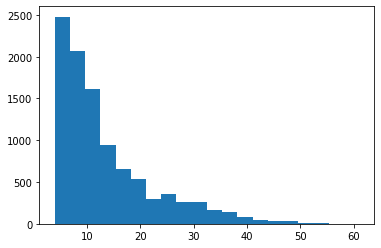

In [276]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(shapes, bins=20)
plt.show()

### K-MNIST

In [12]:
kmnist_train = KMNIST(root="../data/_tmp/", train=True, download=True)
kmnist_test = KMNIST(root="../data/_tmp/", train=False, download=True)

X_kmnist_train, y_kmnist_train = kmnist_train.data, kmnist_train.targets
X_kmnist_test, y_kmnist_test = kmnist_test.data, kmnist_test.targets

In [13]:
X_kmnist_train.shape, X_kmnist_test.shape, y_kmnist_train.shape, y_kmnist_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [14]:
transform_kmnist = Compose([
    Lambda(lambda x: x / 255),
    ToDtype(torch.float32),
])

In [15]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

img = transform_kmnist(X_kmnist_train[9])
img_filtered = f(img)
img_filtered.shape

torch.Size([16, 28, 28])

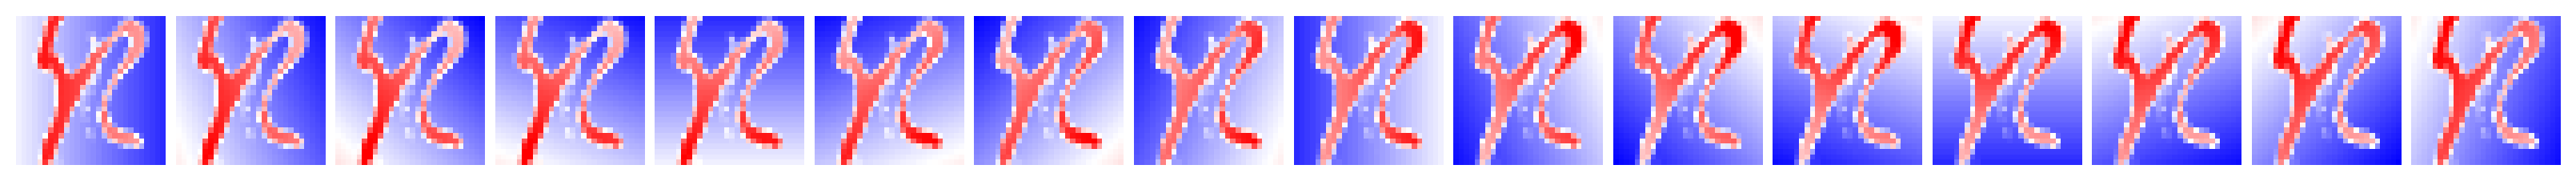

In [19]:
fig, ax = plt.subplots(ncols=len(img_filtered), figsize=(16, 1), dpi=200)
for i in range(len(img_filtered)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[i], vmin=0, vmax=1.8, cmap="bwr")
plt.tight_layout(pad=0.25)
plt.show()

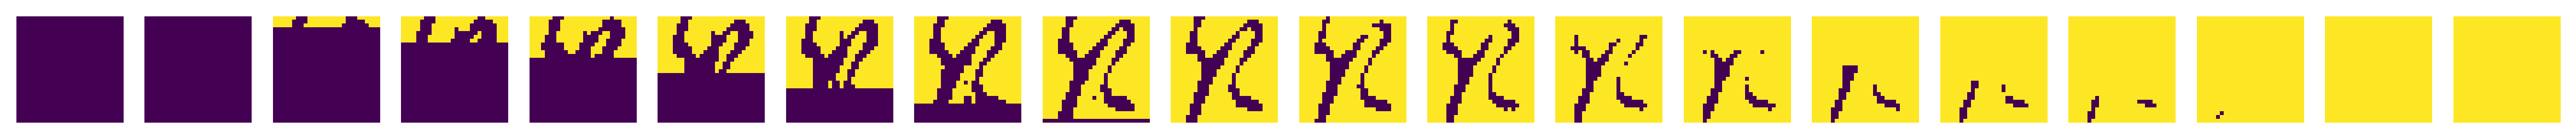

In [20]:
fig, ax = plt.subplots(ncols=20, figsize=(20, 1), dpi=300)
for i, t in enumerate(np.linspace(0, 2, 20)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[4] <= t, vmin=0, vmax=1)
plt.show()

C:\Users\ХХХ\AppData\Local\Temp\ipykernel_10268\2076207902.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr')


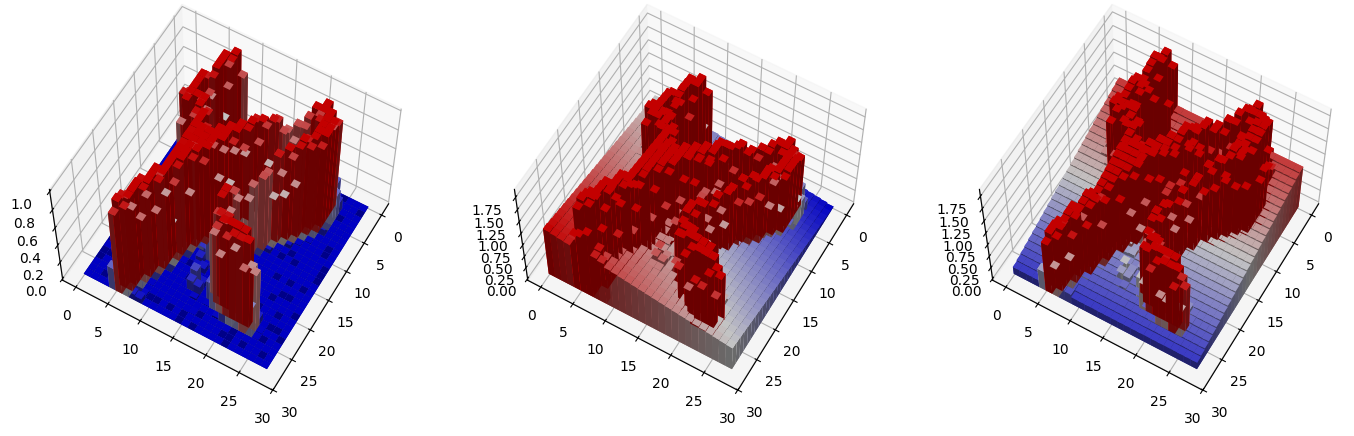

In [21]:
fig, ax = plt.subplots(ncols=3, subplot_kw=dict(projection="3d"), figsize=(17,5))
imshow3d(img, ax[0])
imshow3d(img_filtered[2], ax[1])
imshow3d(img_filtered[12], ax[2])
plt.show()

#### Persistence

In [25]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

X_kmnist_train_ = transform_kmnist(X_kmnist_train)
D_kmnist_train_dir = []

for i, img in enumerate(tqdm(X_kmnist_train_)):
    dgm_pht = pht(f(img), pos=alphas)
    D_kmnist_train_dir.append(dgm_pht)

pickle.dump(D_kmnist_train_dir, open("../data/KMNIST_D_train_dir.pkl", "wb"))

100%|██████████| 60000/60000 [59:28<00:00, 16.82it/s]  


In [24]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

X_kmnist_test_ = transform_kmnist(X_kmnist_test)
D_kmnist_test_dir = []

for i, img in enumerate(tqdm(X_kmnist_test_)):
    dgm_pht = pht(f(img), pos=alphas)
    D_kmnist_test_dir.append(dgm_pht)

pickle.dump(D_kmnist_test_dir, open("../data/KMNIST_D_test_dir.pkl", "wb"))

100%|██████████| 10000/10000 [06:58<00:00, 23.92it/s]


Direction (agg = 'mult')

In [16]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="mult")

X_kmnist_train_ = transform_kmnist(X_kmnist_train)
D_kmnist_train_dir = []

for i, img in enumerate(tqdm(X_kmnist_train_)):
    dgm_pht = pht(f(img), pos=alphas)
    D_kmnist_train_dir.append(dgm_pht)

pickle.dump(D_kmnist_train_dir, open("../data/KMNIST_D_mult_train_dir.pkl", "wb"))

100%|██████████| 60000/60000 [3:00:23<00:00,  5.54it/s]      


In [17]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="mult")

X_kmnist_test_ = transform_kmnist(X_kmnist_test)
D_kmnist_test_dir = []

for i, img in enumerate(tqdm(X_kmnist_test_)):
    dgm_pht = pht(f(img), pos=alphas)
    D_kmnist_test_dir.append(dgm_pht)

pickle.dump(D_kmnist_test_dir, open("../data/KMNIST_D_mult_test_dir.pkl", "wb"))

100%|██████████| 10000/10000 [08:56<00:00, 18.64it/s]


In [298]:
np.quantile(shapes, 0.1), np.median(shapes), np.quantile(shapes, 0.9)

(135.0, 265.0, 452.0)

In [299]:
np.min(shapes), np.mean(shapes), np.max(shapes)

(47.0, 282.2118, 860.0)

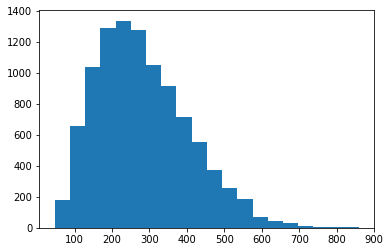

In [300]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(shapes, bins=20)
plt.show()

### Fashion MNIST

In [8]:
fmnist_train = FashionMNIST(root="../data/_tmp/", train=True, download=True)
fmnist_test = FashionMNIST(root="../data/_tmp/", train=False, download=True)

X_fmnist_train, y_fmnist_train = fmnist_train.data, fmnist_train.targets
X_fmnist_test, y_fmnist_test = fmnist_test.data, fmnist_test.targets

In [12]:
X_fmnist_train.shape, X_fmnist_test.shape, y_fmnist_train.shape, y_fmnist_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [13]:
X_fmnist_train[0].shape

torch.Size([28, 28])

In [14]:
transform_fmnist = Compose([
    Lambda(lambda x: x / 255),
    ToDtype(torch.float32, scale=True),
])

In [15]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

img = transform_fmnist(X_fmnist_train[9])
img_filtered = f(img)
img_filtered.shape

torch.Size([16, 28, 28])

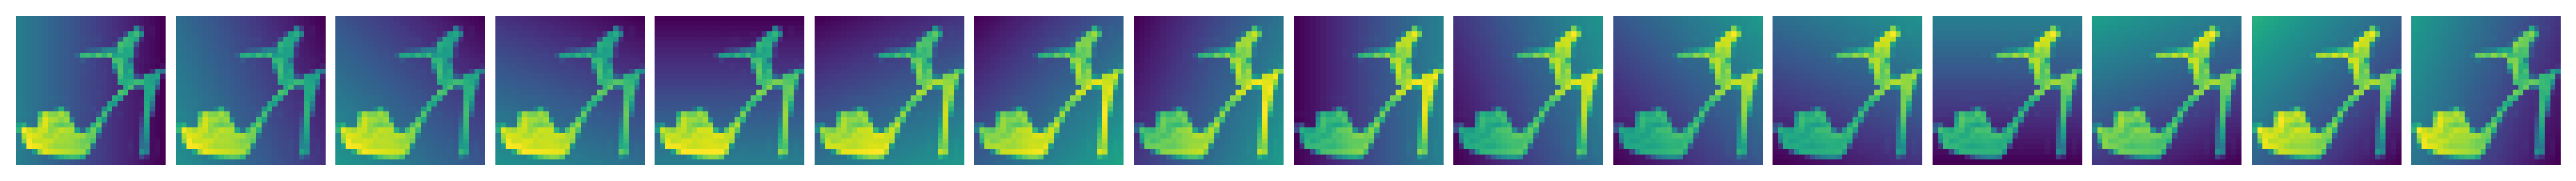

In [16]:
fig, ax = plt.subplots(ncols=len(img_filtered), figsize=(16, 1), dpi=200)
for i in range(len(img_filtered)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[i])
plt.tight_layout(pad=0.25)
plt.show()

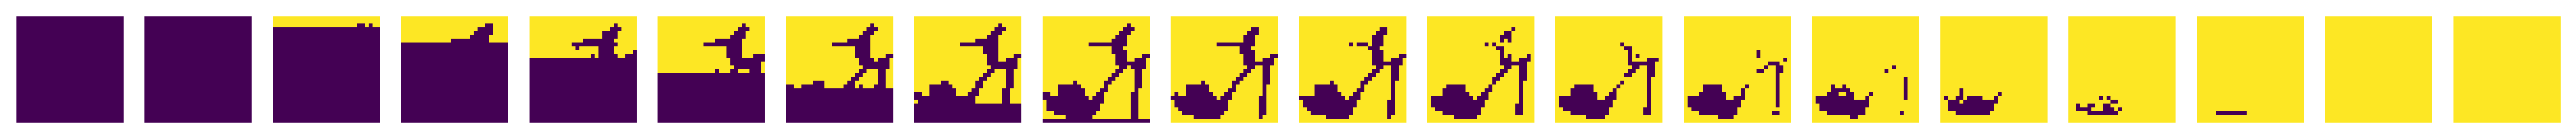

In [17]:
fig, ax = plt.subplots(ncols=20, figsize=(20, 1), dpi=300)
for i, t in enumerate(np.linspace(0, 2, 20)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[4] <= t, vmin=0, vmax=1)
plt.show()

C:\Users\ХХХ\AppData\Local\Temp\ipykernel_8824\2076207902.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr')


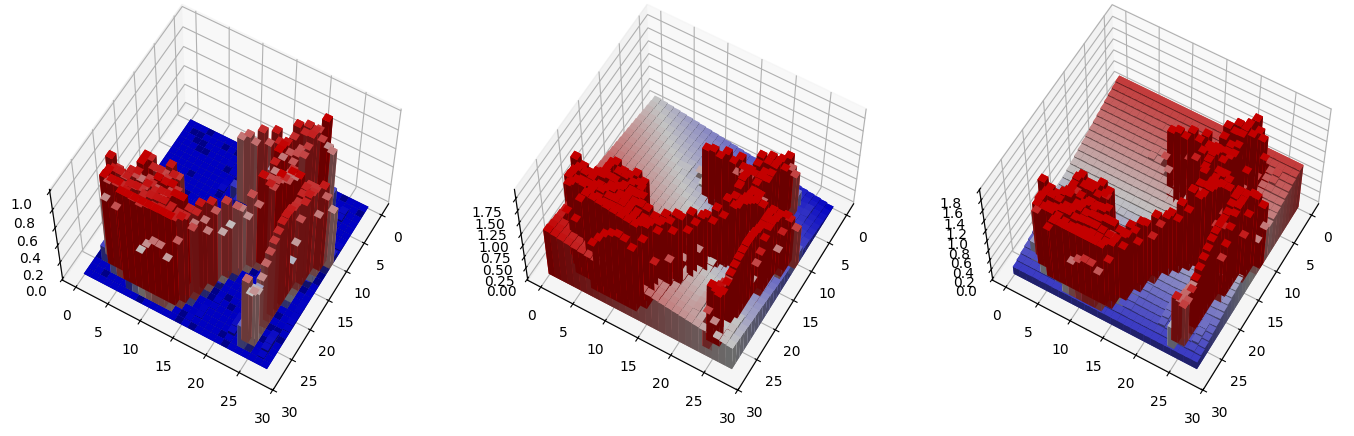

In [18]:
fig, ax = plt.subplots(ncols=3, subplot_kw=dict(projection="3d"), figsize=(17,5))
imshow3d(img, ax[0])
imshow3d(img_filtered[2], ax[1])
imshow3d(img_filtered[12], ax[2])
plt.show()

Persistence

In [20]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

X_fmnist_train_ = transform_fmnist(X_fmnist_train)
D_fmnist_train_dir = []

for i, img in enumerate(tqdm(X_fmnist_train_)):
    dgm_pht = pht(f(img), pos=alphas, eps=0.05)
    D_fmnist_train_dir.append(dgm_pht)

pickle.dump(D_fmnist_train_dir, open("../data/FMNIST_D_train_dir.pkl", "wb"))

100%|██████████| 60000/60000 [55:38<00:00, 17.97it/s]  


In [19]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

X_fmnist_test_ = transform_fmnist(X_fmnist_test)
D_fmnist_test_dir = []

for i, img in enumerate(tqdm(X_fmnist_test_)):
    dgm_pht = pht(f(img), pos=alphas, eps=0.05)
    D_fmnist_test_dir.append(dgm_pht)

pickle.dump(D_fmnist_test_dir, open("../data/FMNIST_D_test_dir.pkl", "wb"))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [08:34<00:00, 19.43it/s]


### CIFAR10

In [29]:
cifar_train = CIFAR10(root="../data/_tmp/", train=True, download=True)
cifar_test = CIFAR10(root="../data/_tmp/", train=False, download=True)

X_cifar_train, y_cifar_train = torch.tensor(cifar_train.data), torch.tensor(cifar_train.targets)
X_cifar_test, y_cifar_test = torch.tensor(cifar_test.data), torch.tensor(cifar_test.targets)

100%|██████████| 170M/170M [01:58<00:00, 1.44MB/s] 


In [30]:
X_cifar_train.shape, X_cifar_test.shape, y_cifar_train.shape, y_cifar_test.shape

(torch.Size([50000, 32, 32, 3]),
 torch.Size([10000, 32, 32, 3]),
 torch.Size([50000]),
 torch.Size([10000]))

In [39]:
X_cifar_train[0].shape

torch.Size([32, 32, 3])

In [31]:
transform_cifar = Compose([
    Lambda(lambda x: x / 255),
    Grayscale(),
    ToDtype(torch.float32),
])

In [32]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

img = transform_cifar(X_cifar_train[1].permute(2, 0, 1)).squeeze(0)
img_filtered = f(img)
img_filtered.shape

torch.Size([16, 32, 32])

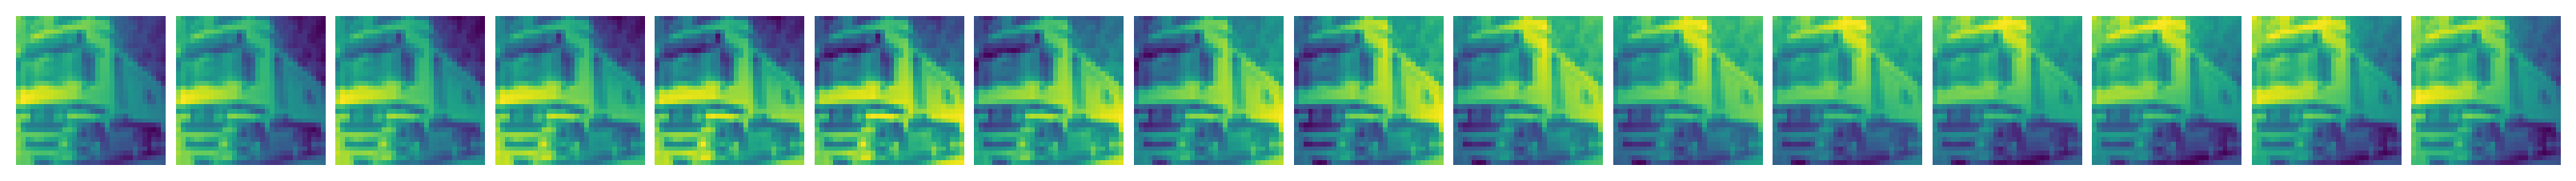

In [33]:
fig, ax = plt.subplots(ncols=len(img_filtered), figsize=(16, 1), dpi=200)
for i in range(len(img_filtered)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[i])
plt.tight_layout(pad=0.25)
plt.show()

C:\Users\ХХХ\AppData\Local\Temp\ipykernel_8824\2076207902.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr')


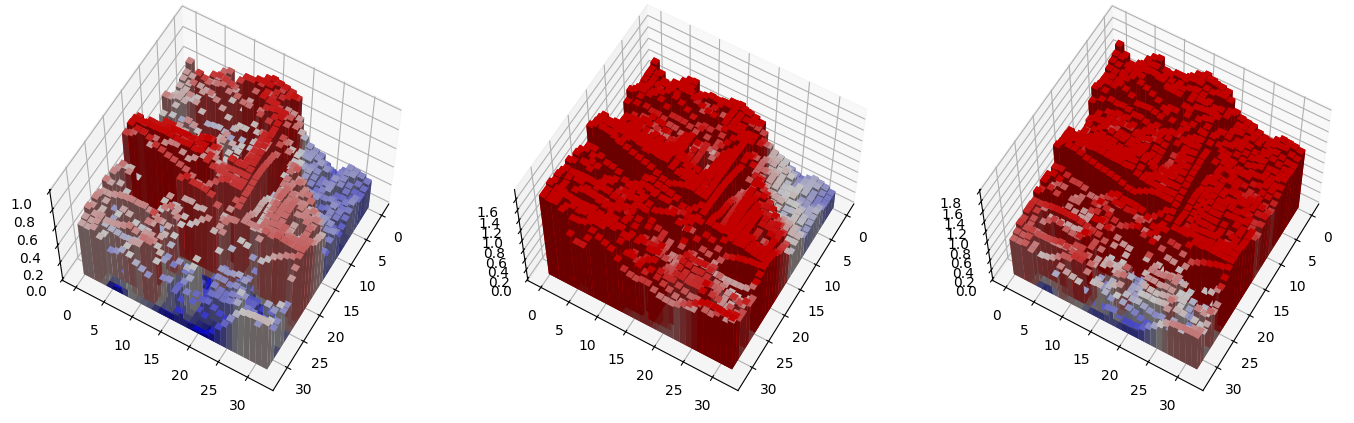

In [34]:
fig, ax = plt.subplots(ncols=3, subplot_kw=dict(projection="3d"), figsize=(17,5))
imshow3d(img, ax[0])
imshow3d(img_filtered[2], ax[1])
imshow3d(img_filtered[12], ax[2])
plt.show()

In [44]:
from torchvision import datasets
from torchvision.datasets import MNIST, KMNIST, CIFAR10, FashionMNIST

dataset_base_test = datasets.CIFAR10(root="./data/_tmp/", train=False, download=True)

100%|██████████| 170M/170M [01:47<00:00, 1.59MB/s] 


In [46]:
dataset_base_train = datasets.CIFAR10(root="./data/_tmp/", train=True, download=True)

Persistence

In [40]:
transform_cifar_1 = Compose([
    Lambda(lambda x: x / 255),
    Lambda(lambda x: x.permute(0, 3, 1, 2)),
    Grayscale(),
    ToDtype(torch.float32),
])

In [41]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

X_cifar_train_ = transform_cifar_1(X_cifar_train)
D_cifar_train_dir = []

for i, img in enumerate(tqdm(X_cifar_train_)):
    dgm_pht = pht(f(img), pos=alphas, eps=0.05)
    D_cifar_train_dir.append(dgm_pht)

pickle.dump(D_cifar_train_dir, open("../data/CIFAR_D_train_dir.pkl", "wb"))

100%|██████████| 50000/50000 [55:32<00:00, 15.00it/s]  


In [42]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

X_cifar_test_ = transform_cifar_1(X_cifar_test)
D_cifar_test_dir = []

for i, img in enumerate(tqdm(X_cifar_test_)):
    dgm_pht = pht(f(img), pos=alphas, eps=0.05)
    D_cifar_test_dir.append(dgm_pht)

pickle.dump(D_cifar_test_dir, open("../data/CIFAR_D_test_dir.pkl", "wb"))

100%|██████████| 10000/10000 [10:06<00:00, 16.48it/s]
